# Human-intepretable Machine Learning - The road to Explainable AI

In this tutorial we will take a look at various ways to explain potential black-box machine learning models in a model-agnostic way. We will be working on a real-world dataset on Census income, also known as the Adult dataset available in the UCI ML Repository where we will be predicting if the potential income of people is more than $50K/yr or not.

The purpose of this tutorial is manifold. The first main objective is to familiarize ourselves with the major state-of-the-art model interpretation frameworks out there (a lot of them being extensions of LIME - the original framework and approach proposed for model interpretation).

[__LIME__](https://github.com/marcotcr/lime) (short for local interpretable model-agnostic explanations) is based on the work presented in the paper, ["Why Should I Trust You?": Explaining the Predictions of Any Classifier"](https://arxiv.org/pdf/1602.04938.pdf) which talks about a novel explanation technique that explains the predictions of any classifier in an interpretable and faithful manner, by learning an interpretable model locally around the prediction. It also covers a method to explain models by presenting representative individual predictions and their explanations in a non-redundant way.

We cover usage of the following model interpretation frameworks in our tutorial.
- [__ELI5__](https://github.com/TeamHG-Memex/eli5)
- [__Skater__](https://github.com/datascienceinc/Skater)
- [__SHAP__](https://github.com/slundberg/shap)

The major model interpretation techniques we will be covering in this tutorial include the following.
- Feature Importances
- Partial Dependence Plots
- Model Prediction Explanations with Local Interpretation
- Model Prediction Explanation with SHAP values
- Dependence & Interaction Plots with SHAP

_Tutorial by [Dipanjan (DJ) Sarkar](https://www.linkedin.com/in/dipanzan/)_

# Load necessary dependencies

In [199]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

# Load the Census Income Dataset

In [7]:
data, labels = shap.datasets.adult(display=True)
data.shape, labels.shape

((32561, 12), (32561,))

# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

We have a total of 12 features and our objective is to predict if the income of a person will be more than \$50K (True) or less than \$50K (False). Hence we will be building and interpreting a classification model

In [8]:
data.head()

Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


# Basic Feature Engineering
Here we convert the categorical columns with string values to numeric representations. 
Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [25]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

## Viewing distribution of people with <=  \$50K (False) and > \$50K (True) income

In [27]:
Counter(labels)

Counter({False: 24720, True: 7841})

# Building Train and Test Datasets

For any machine learning model, we always need train and test datasets. We will be building the model on the train dataset and test the performance on the test dataset. We maintain two datasets (one with the encoded categorical values and one with the original values) so we can train with the encoded dataset but use the original dataset as needed later on for model interpretation. 

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 12), (9769, 12))

In [228]:
X_train.head(3)

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  34.0          6            9.0               2           5             5   
1  48.0          6           10.0               2           3             0   
2  23.0          7           10.0               2          10             0   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    0           0.0        2179.0            12.0       39  
1     0    1        7688.0           0.0            40.0       39  
2     4    1           0.0           0.0            30.0       39

In [227]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train, y_test = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
X_train_disp.shape, X_test_disp.shape

((22792, 12), (9769, 12))

In [229]:
X_train_disp.head(3)

Age          Workclass  Education-Num       Marital Status  \
19749  34.0   Self-emp-not-inc            9.0   Married-civ-spouse   
1216   48.0   Self-emp-not-inc           10.0   Married-civ-spouse   
27962  23.0          State-gov           10.0   Married-civ-spouse   

             Occupation Relationship                 Race      Sex  \
19749   Farming-fishing         Wife                White   Female   
1216       Craft-repair      Husband   Amer-Indian-Eskimo     Male   
27962    Prof-specialty      Husband                White     Male   

       Capital Gain  Capital Loss  Hours per week         Country  
19749           0.0        2179.0            12.0   United-States  
1216         7688.0           0.0            40.0   United-States  
27962           0.0           0.0            30.0   United-States

# Training the classification model

We will now train and build a basic boosting classification model on our training data using the popular [XGBoost](https://xgboost.readthedocs.io/en/latest/) 
framework, an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable 

In [140]:
%%time

import xgboost as xgb

xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 19.7 s, sys: 12.7 ms, total: 19.7 s
Wall time: 19.7 s


# Making predictions on the test data

Here we do the usual, use the trained model to make predictions on the test dataset

In [115]:
predictions = xgc.predict(X_test)
predictions[:10]

array([False, False,  True, False, False,  True,  True, False, False,
        True])

# Model Performance Evaluation

Time to put the model to the test! Let's evaluate how our model has performed with its predictions on the test data. 
We use my nifty `model_evaluation_utils` module for this which leverages `scikit-learn` internally to give us 
standard classification model evaluation metrics

In [116]:
class_labels = list(set(labels))
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=predictions, classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
             precision    recall  f1-score   support

      False       0.90      0.94      0.92      7455
       True       0.76      0.67      0.71      2314

avg / total       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                   False True 
Actual: False       6972   483
        True         775  1539


# Default Model Interpretation Methods

By default it is difficult to gauge on specific model interpretation methods for machine learning models out of the box. 
Parametric models like logistic regression are easier to interpret given that the total number of parameters of the model
are fixed regardless of the volume of data and one can make some interpretation of the model's prediction decisions leveraging
the parameter coefficients.

Non-parametric models are harder to interpret given that the total number of parameters remain unbounded and increase
with the increase in the data volume. Some non-parametric models like tree-based models do have some out of the box model 
interpretation methods like feature importance which helps us in understanding which features might be influential in
the model making its prediction decisions

## Classic feature importances from XGBoost

Here we try out the global feature importance calcuations that come with XGBoost. The model enables us to view feature importances based on the following.
- Feature Weights: 
- Gain
- Coverage

Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency guarantees (meaning they will order the features correctly).

Text(0.5,1,'Feature Importance - Sample Coverage')

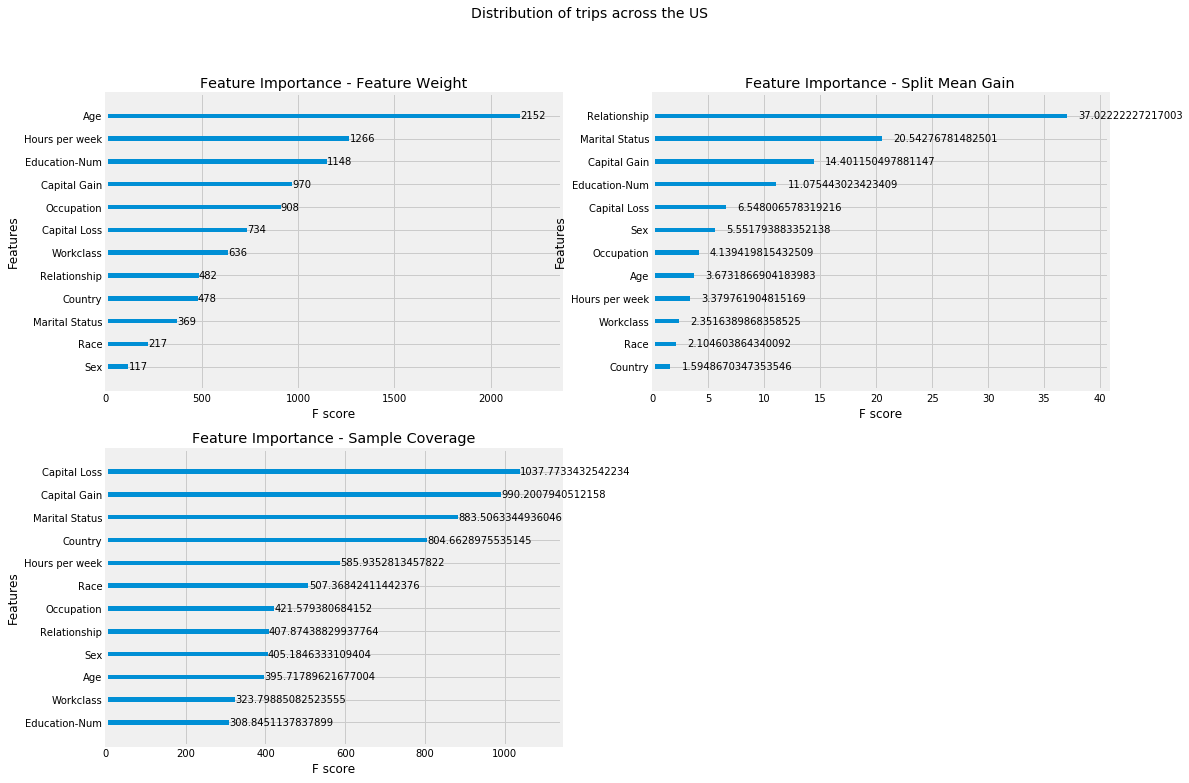

In [117]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Distribution of trips across the US", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
ax3.set_title("Feature Importance - Sample Coverage")

# Model Interpretation with ELI5

In [219]:
eli5.show_weights(xgc.get_booster())

In [220]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], feature_names=list(data.columns) ,show_feature_values=True)

Actual Label: False
Predicted Label: False


In [221]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], feature_names=list(data.columns) ,show_feature_values=True)

Actual Label: True
Predicted Label: True


# Model Interpretation with Skater

In [223]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [224]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, target_names=['Inc <= 50K', 'Inc > 50K'])

2018-10-27 16:27:34,562 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 11 seconds

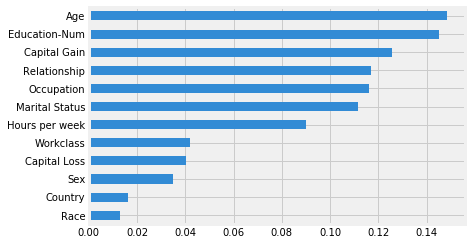

In [225]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, n_samples=23000)

2018-10-27 14:33:44,423 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[42/42] grid cells ████████████████████ Time elapsed: 13 seconds

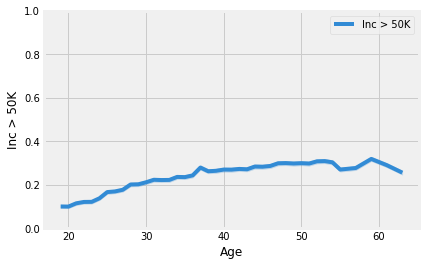

In [68]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

2018-10-27 14:38:25,198 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[3/3] grid cells ████████████████████ Time elapsed: 1 seconds

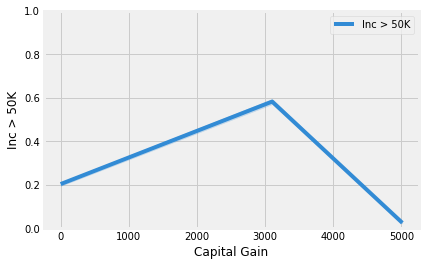

In [79]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

In [85]:
pd.concat([data_disp[['Relationship']], data[['Relationship']]], axis=1).drop_duplicates()

Relationship  Relationship
0     Not-in-family             1
1           Husband             0
4              Wife             5
12        Own-child             3
17        Unmarried             4
74   Other-relative             2

2018-10-27 14:39:23,867 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 3 seconds

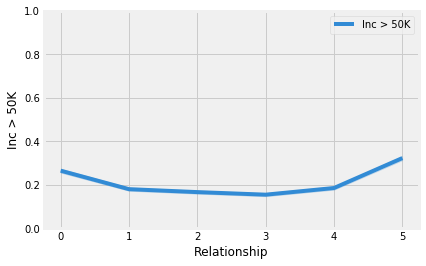

In [80]:
r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], im_model, grid_resolution=50, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

2018-10-27 14:43:31,391 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[355/355] grid cells ████████████████████ Time elapsed: 127 seconds

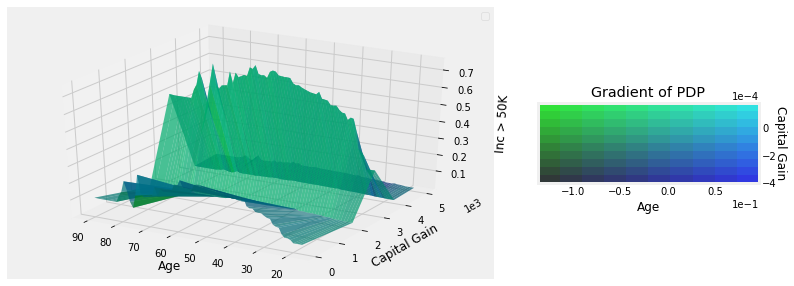

In [87]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Capital Gain')], 
                                                                    im_model, n_samples=1000, 
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

In [173]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [133]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), 
                           discretize_continuous=True, 
                           class_names=['Inc <= 50K', 'Inc > 50K'])

In [175]:
print(y_test[0])
exp.explain_instance(X_test.iloc[0].values, xgc_np.predict_proba).show_in_notebook()

False


In [139]:
print(y_test[2])
exp.explain_instance(X_test.iloc[2].values, xgc_np.predict_proba).show_in_notebook()

True


# Model Interpretation with SHAP

In [163]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)

In [171]:
explainer.expected_value

-1.3625857

In [176]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

In [177]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

In [179]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_disp.iloc[:1000,:])

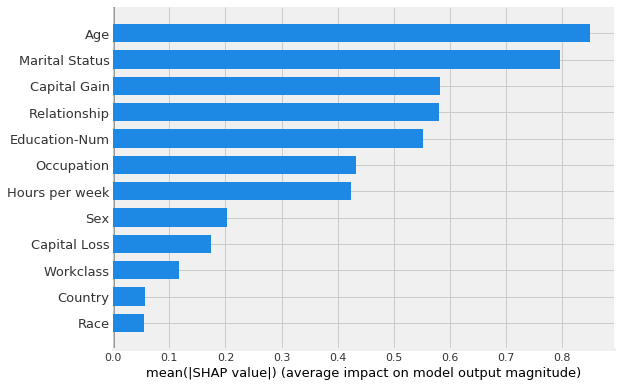

In [180]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

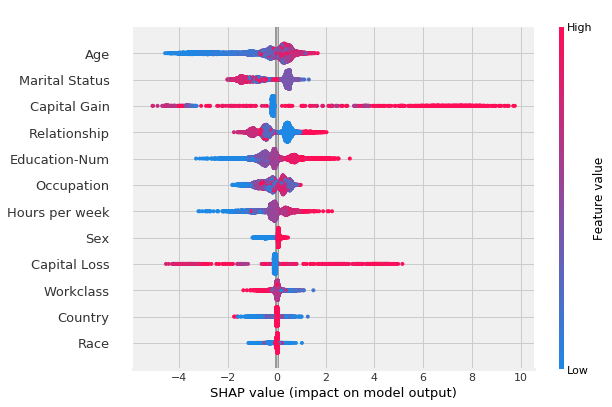

In [181]:
shap.summary_plot(shap_values, X_test)

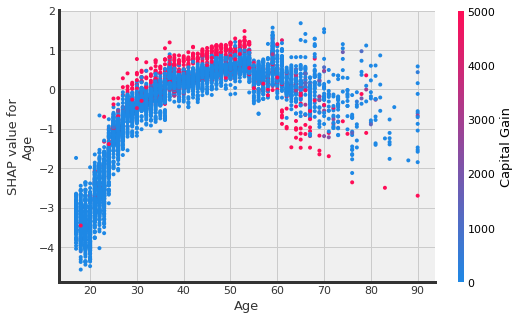

In [188]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

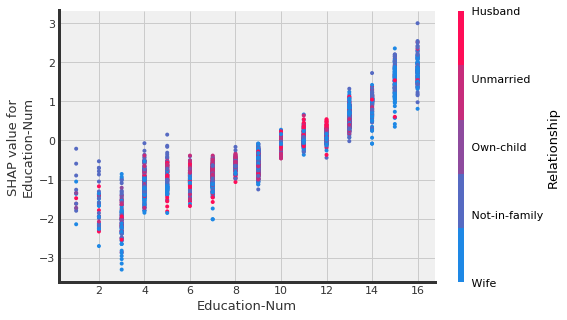

In [194]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

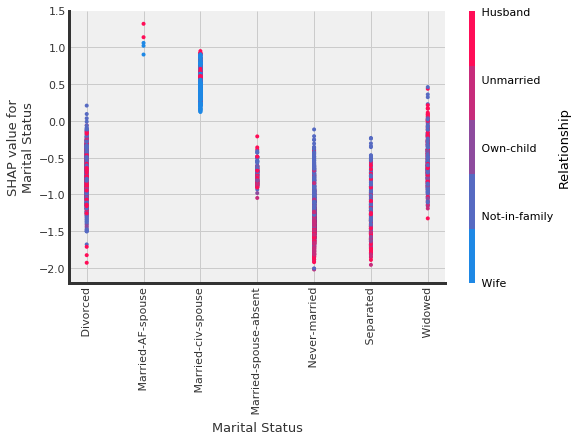

In [191]:
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

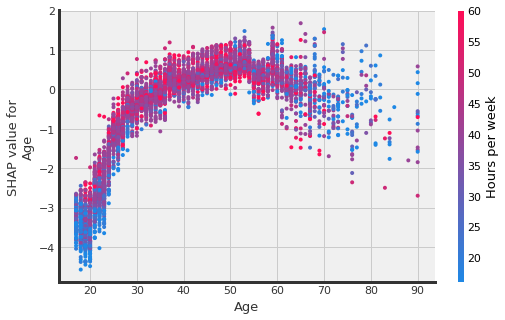

In [198]:
shap.dependence_plot(ind='Age', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)